# LSH 13-1 (kelly [0] Method1, df_~ & [1] ReLU~), 05-3

In [1]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# data load

In [8]:
# all_df_preds = pd.read_csv('./dsml_data/df_all_best_for_meth1.csv') # for sign (diff_preds)
all_df = pd.read_csv('./dsml_data/df_all_best.csv') # for ReLU (diff)
df_d1d5 = pd.read_csv('./dsml_data/df_d1d5_best.csv')
df_d6d10 = pd.read_csv('./dsml_data/df_d6d10_best.csv')

# All reversed

In [9]:
all_df = all_df.sort_values(by = 'diff', ascending = False)
all_df['feature'][:10].values

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
            227194,    54858516,    74706811,    45006701,     4003822],
      dtype=int64)

# 1~5 reversed

In [10]:
df_d1d5 = df_d1d5.sort_values(by='diff',ascending = False)
df_d1d5['feature'][:10].values

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
          54858516,    74706811,    45006701,      228125, 63323016501],
      dtype=int64)

# 6~10 reversed

In [11]:
df_d6d10 = df_d6d10.sort_values(by = 'diff', ascending = False)
df_d6d10['feature'][:10].values

array([     227194,       50889,       51200,   182138167,   517293025,
           4003822,       51362, 63323038810,       51143,   904585461],
      dtype=int64)

# absum 함수 (1~5번 과정)
abnormal sum 해주는 함수

In [26]:
total_data = pd.read_csv('./dsml_data/total_data_7727.csv')
x = np.load('./dsml_data/x_(7727,10,4068).npy')

def absum(PPL_list):
    #1) PRE_top10의 index 구하기
    PPL_top10 = PPL_list[:10]
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)

    #2) 생존자 index 구하기
    sub7727 = total_data['SUBJECT_ID'].unique()
    
    patient = pd.read_csv('./dsml_data/폐렴환자.csv')
    patient = patient.sort_values(by = 'SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
    
    #3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())
    
    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:] / x_생존자.shape[0]
    
    
    #4) 사망자 4718명의 D-10 ~ D-1 feature 별 abnormal sum
    사망자_index = list(set(range(0,7727)) - set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())
        
    
    result2 = (np.array(result2)).reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i] / x_사망자.shape[0]
    
    #5) for 문으로 각 feature에 대한 비율 추이 그래프 그리기
    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()
    
    _ = plt.figure(figsize = (13,12), dpi = 150)
    for i, f in enumerate(PPL_top10):
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _= ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _= ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = [f'{f}_사망', f'{f}_생존'], loc = 'upper left', fontsize = 12)
        _ = ax.set_ylabel('per', fontsize = 12)
    plt.tight_layout()



# All - Top 10 그래프
```
7717 명 중 사망: 4718, 생존: 3009
```

In [15]:
all_df = all_df.sort_values(by = 'diff', ascending = False)
all_feature = all_df['feature'].tolist()

# LAB, PRE, PRO의 item_list 생성
LAB_item = total_data[total_data['TYPE'] == 'LAB']['ITEMID'].unique()
PRE_item = total_data[total_data['TYPE'] == 'PRE']['ITEMID'].unique()
PRO_item = total_data[total_data['TYPE'] == 'PRO']['ITEMID'].unique()

LAB_list = []
PRE_list = []
PRO_list = []

for i in all_feature:
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

## PRE - top10

C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47581 missing from cur

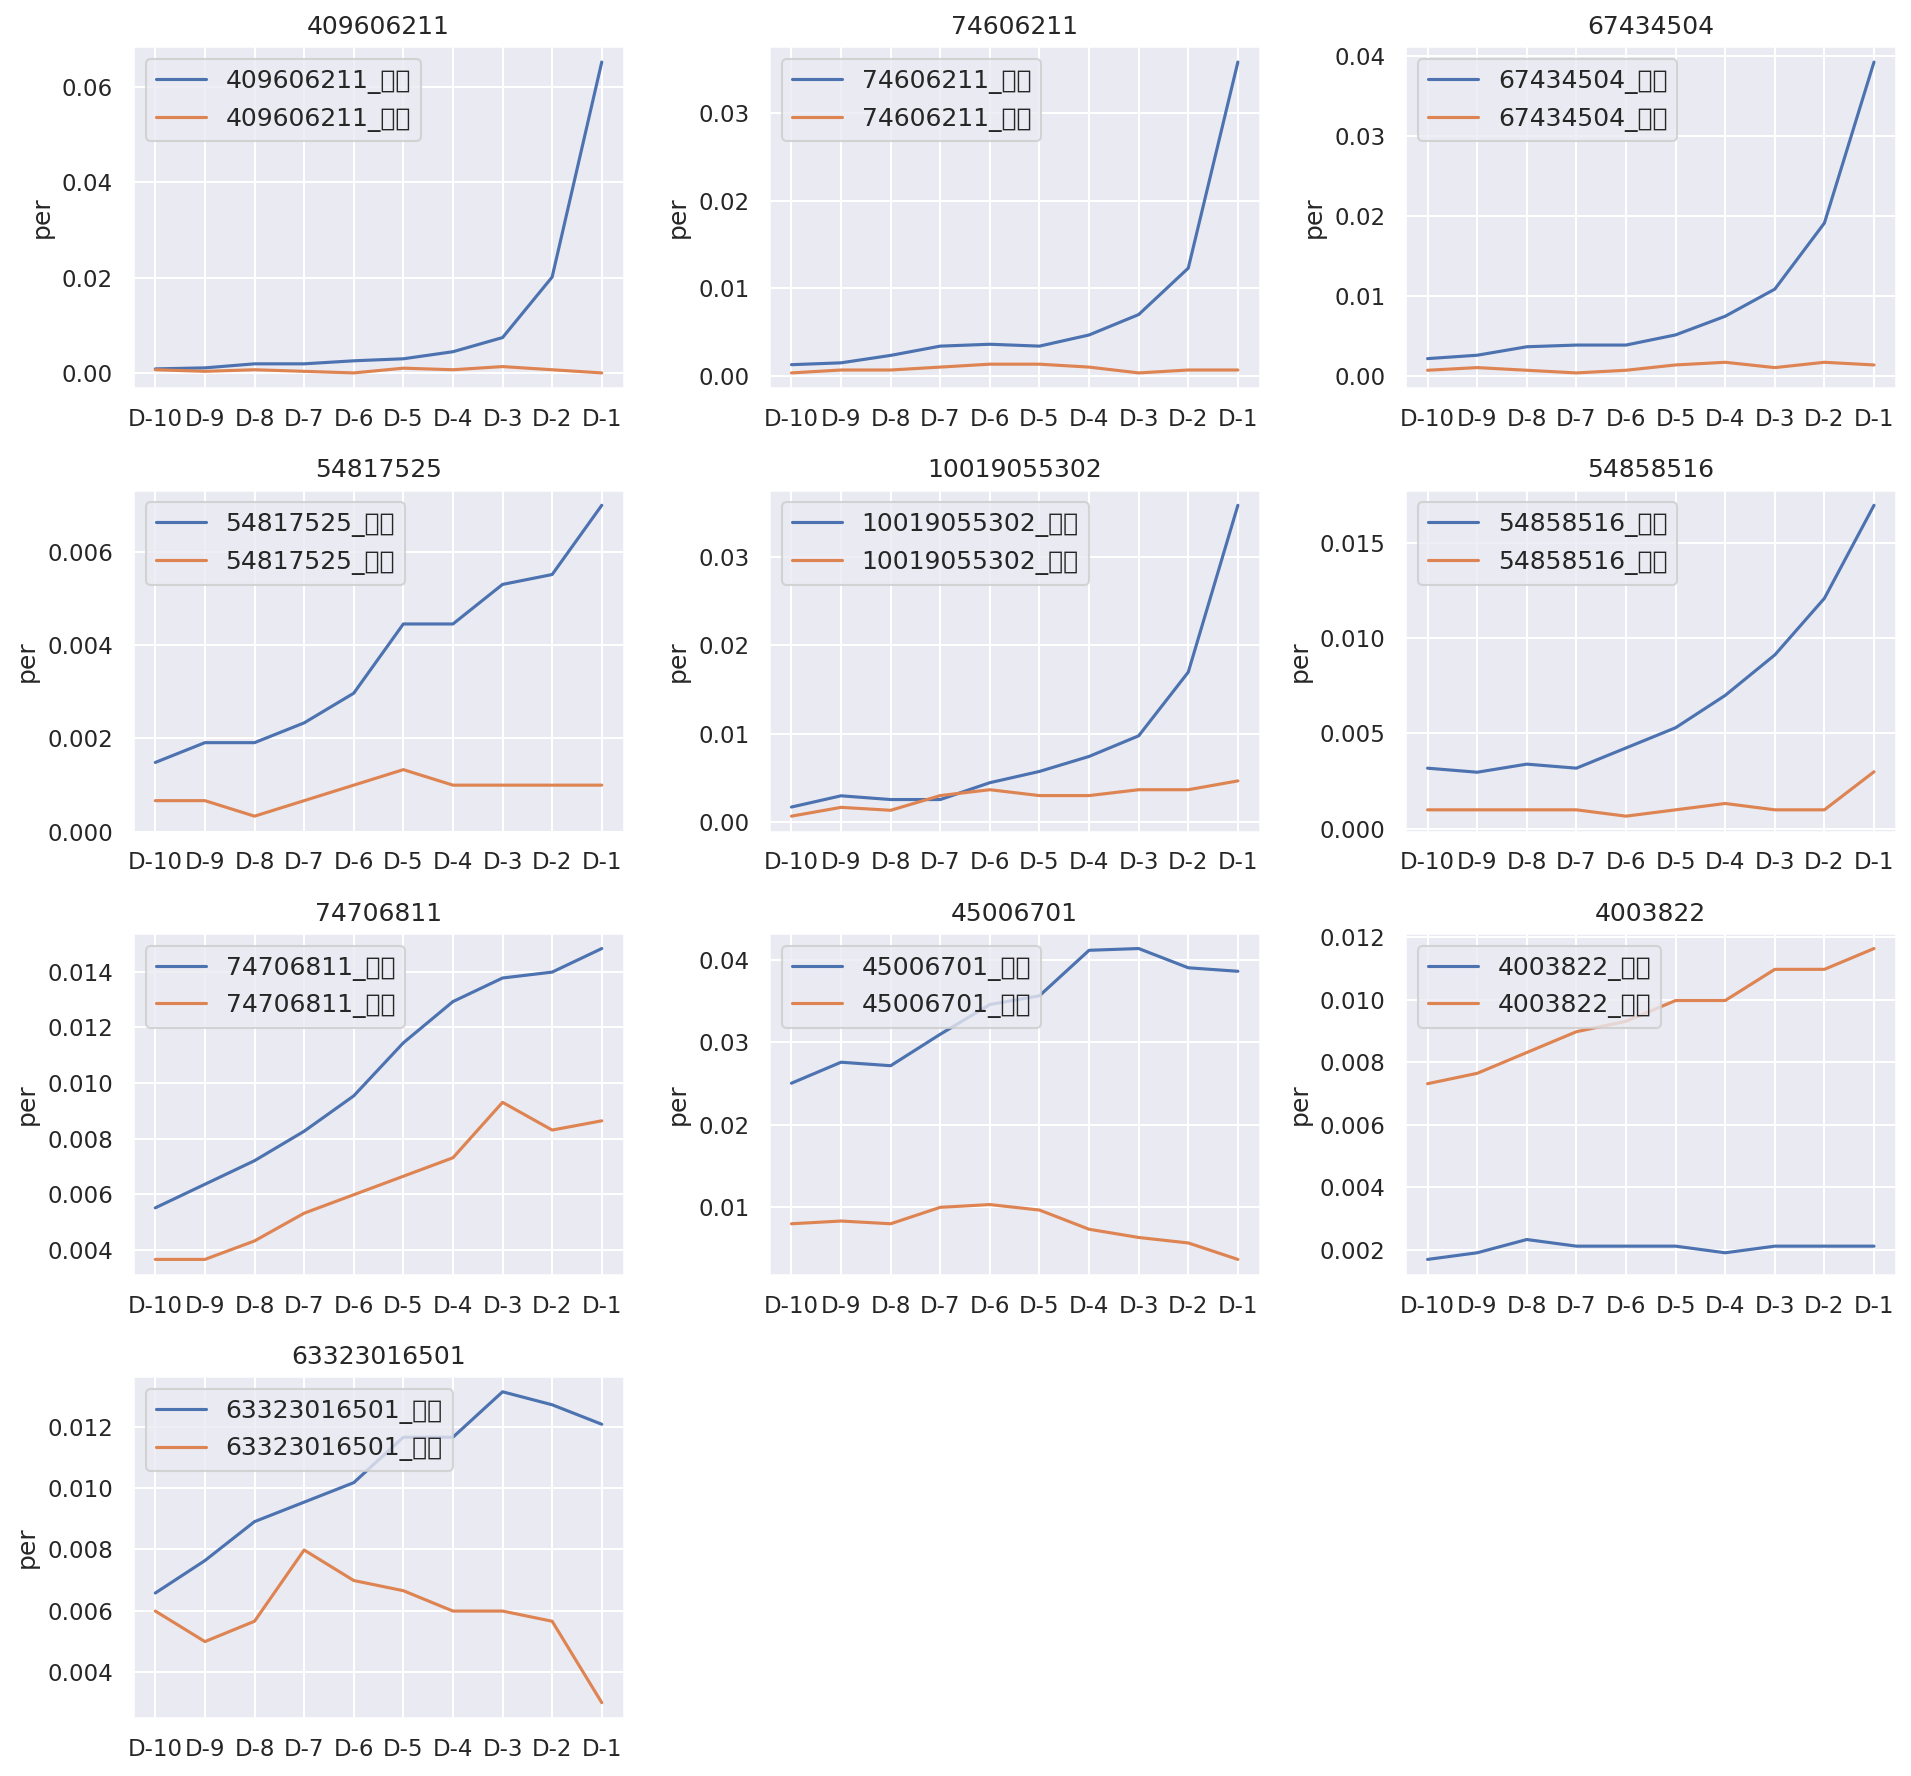

In [27]:
absum(PRE_list)

## PRO - top10

C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47581 missing from cur

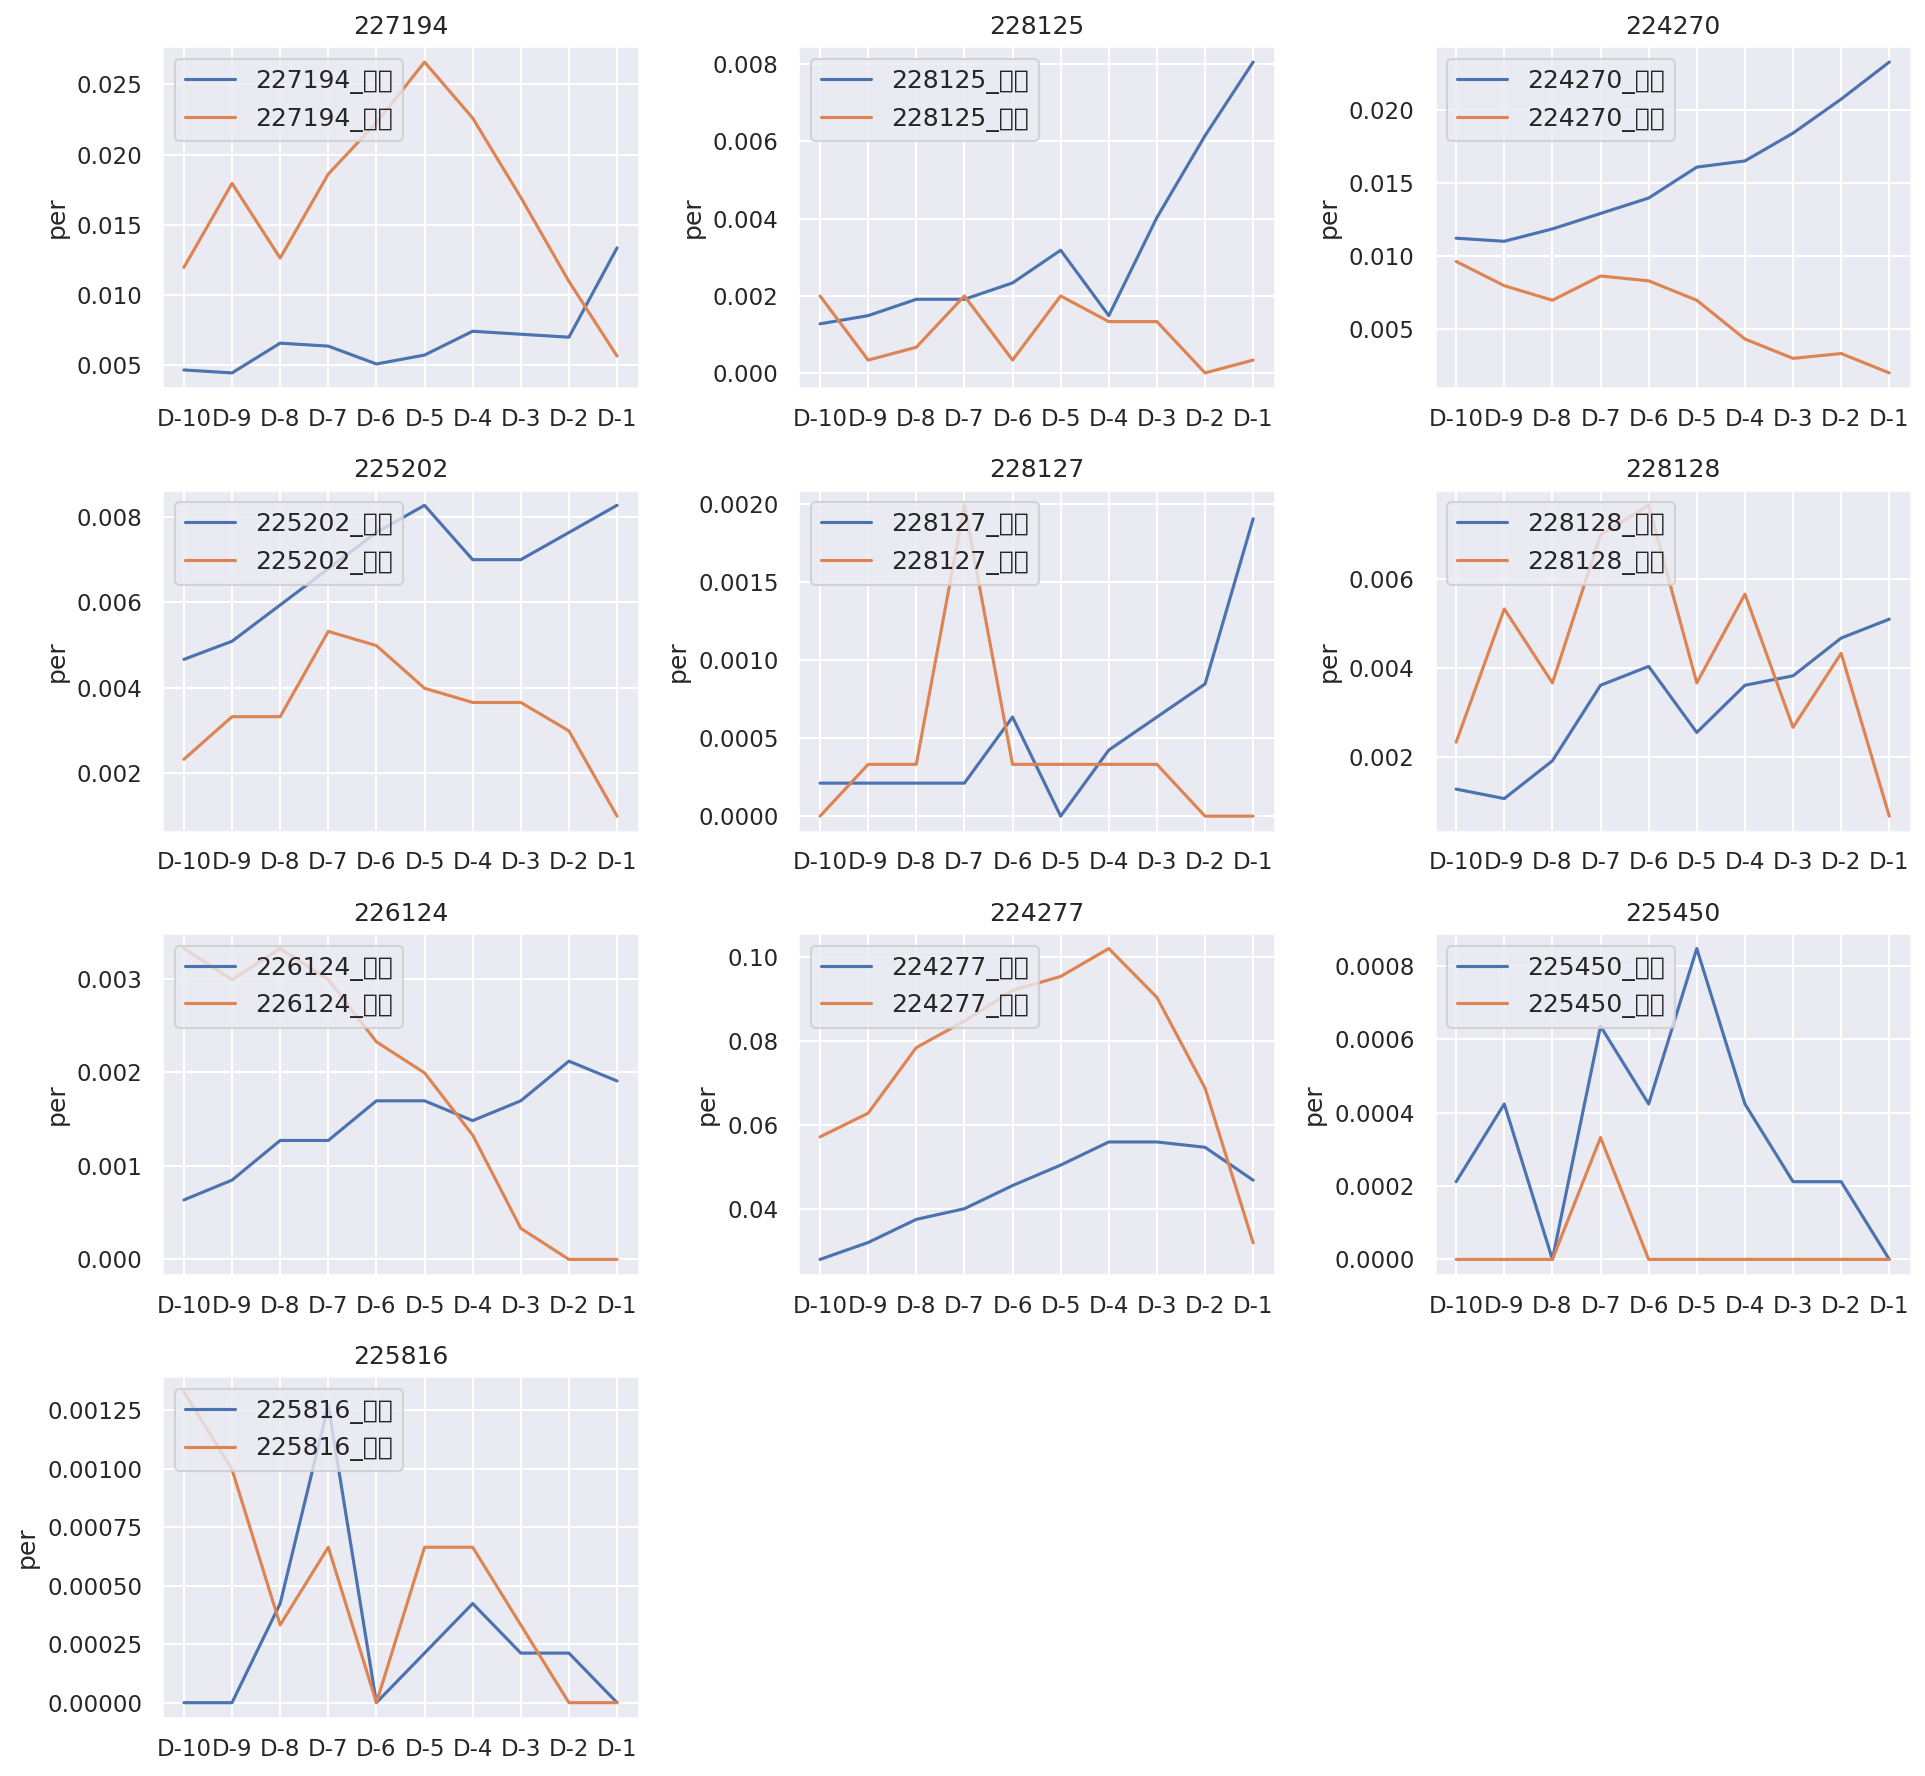

In [28]:
absum(PRO_list)

## LAB - top10

C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\kelly\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47581 missing from cur

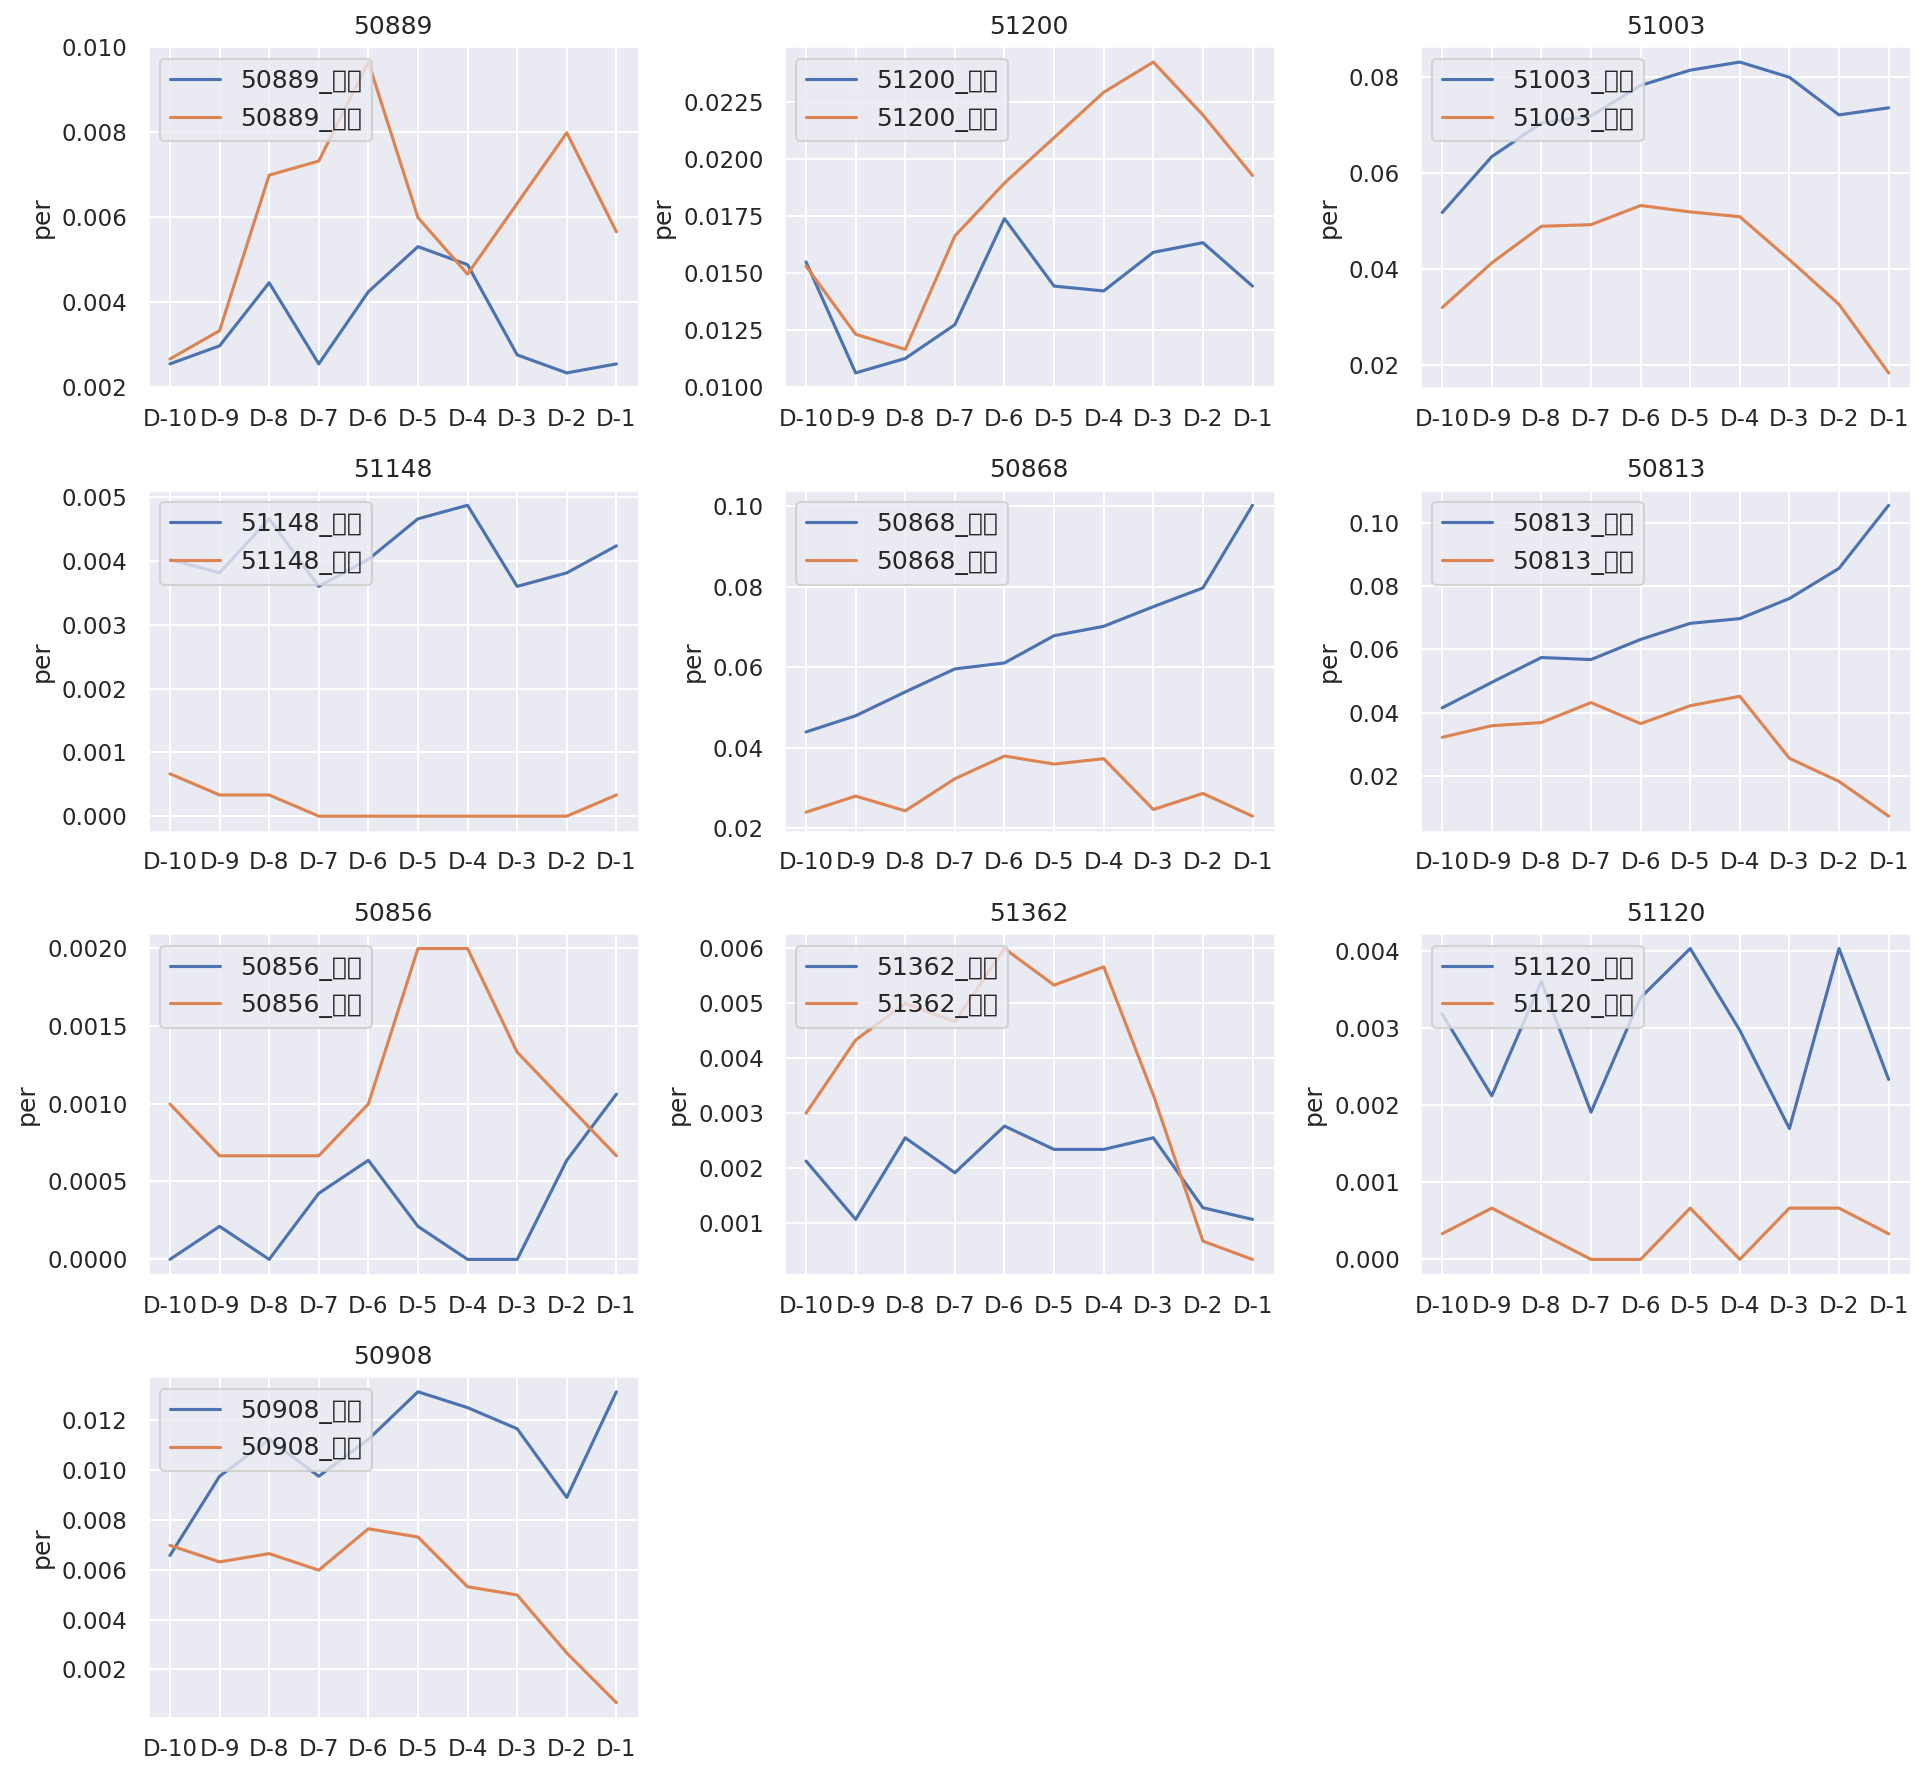

In [29]:
absum(LAB_list)